# Homework Starter — Stage 10b: Time Series & Classification

In [1]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

## Option A: Own Data

In [3]:
df = pd.read_csv('../data/options_data_20250823_163952.csv')

print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset Overview:
Shape: (496, 18)

Columns: ['symbol', 'underlying_symbol', 'strike', 'expiration_date', 'contract_type', 'implied_volatility', 'open_interest', 'volume', 'bid', 'ask', 'last_price', 'market_price', 'underlying_price', 'risk_free_rate', 'fetch_timestamp', 'time_to_expiry', 'data_source', 'simulated_trade_date']

First few rows:


,symbol,underlying_symbol,strike,expiration_date,contract_type,implied_volatility,open_interest,volume,bid,ask,last_price,market_price,underlying_price,risk_free_rate,fetch_timestamp,time_to_expiry,data_source,simulated_trade_date
0,SPY20250825C00530000,SPY,530.0,2025-08-25,call,0.841798,11.0,11.0,113.98,116.78,106.25,115.380,645.309998,0.04088,2025-08-23 16:39:40.712793,0.00274,yahoo_finance,2025-08-22 16:39:41.671421
1,SPY20250825C00550000,SPY,550.0,2025-08-25,call,0.703128,2.0,2.0,93.98,96.79,96.12,95.385,645.309998,0.04088,2025-08-23 16:39:40.712793,0.00274,yahoo_finance,2025-08-22 16:39:41.671421
2,SPY20250825C00570000,SPY,570.0,2025-08-25,call,0.565434,2.0,240.0,73.99,76.79,75.03,75.390,645.309998,0.04088,2025-08-23 16:39:40.712793,0.00274,yahoo_finance,2025-08-22 16:39:41.671421
3,SPY20250825C00580000,SPY,580.0,2025-08-25,call,0.813478,3.0,233.0,63.99,66.80,66.14,65.395,645.309998,0.04088,2025-08-23 16:39:40.712793,0.00274,yahoo_finance,2025-08-22 16:39:41.671421
4,SPY20250825C00590000,SPY,590.0,2025-08-25,call,0.710940,1.0,284.0,53.99,56.80,55.93,55.395,645.309998,0.04088,2025-08-23 16:39:40.713785,0.00274,yahoo_finance,2025-08-22 16:39:41.671421


## 1. Data Preparation and Feature Engineering

In [4]:
# Convert timestamps and sort by time
df['simulated_trade_date'] = pd.to_datetime(df['simulated_trade_date'])
df = df.sort_values('simulated_trade_date').reset_index(drop=True)

# Returns from market_price
df['ret'] = df['market_price'].pct_change()

# Lag and rolling features
df['lag_1'] = df['ret'].shift(1)
df['lag_2'] = df['ret'].shift(2)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)
df['roll_std_5'] = df['ret'].rolling(5).std().shift(1)
df['roll_max_5'] = df['ret'].rolling(5).max().shift(1)
df['momentum_3'] = (df['market_price'] / df['market_price'].shift(3) - 1).shift(1)

# To create Targets
df['y_next_ret'] = df['ret'].shift(-1)  # Forecasting target
df['y_up'] = (df['y_next_ret'] > 0).astype(int)  # Classification target

# NaN value rows removed
df_clean = df.dropna().copy()

print(f"Dataset shape after cleaning: {df_clean.shape}")
print(f"Features created: lag_1, lag_2, roll_mean_5, roll_std_5, roll_max_5, momentum_3")

Dataset shape after cleaning: (489, 27)
Features created: lag_1, lag_2, roll_mean_5, roll_std_5, roll_max_5, momentum_3


## 2. Time-Aware Split

In [5]:
# Time-aware split (80-20)
split_idx = int(len(df_clean) * 0.8)
train_data = df_clean.iloc[:split_idx]
test_data = df_clean.iloc[split_idx:]

# Features Defined here
features = ['lag_1', 'lag_2', 'roll_mean_5', 'roll_std_5', 'roll_max_5', 'momentum_3']

X_train, X_test = train_data[features], test_data[features]
y_train_reg, y_test_reg = train_data['y_next_ret'], test_data['y_next_ret']
y_train_clf, y_test_clf = train_data['y_up'], test_data['y_up']

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 391, Test size: 98


## 3. Pipeline Implementation - Regression

In [7]:
# Regression Pipeline
reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Fit and predict
reg_pipeline.fit(X_train, y_train_reg)
y_pred_reg = reg_pipeline.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))

print(f"Regression Results:")
print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")

Regression Results:
MAE: 567.496790
RMSE: 1209.011795


## 4. Pipeline Implementation - Classification

In [8]:
# Classification Pipeline
clf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Fit and predict
clf_pipeline.fit(X_train, y_train_clf)
y_pred_clf = clf_pipeline.predict(X_test)

# Evaluation metrics
print(f"\nClassification Results:")
print(classification_report(y_test_clf, y_pred_clf))


Classification Results:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73        56
           1       0.00      0.00      0.00        42

    accuracy                           0.57        98
   macro avg       0.29      0.50      0.36        98
weighted avg       0.33      0.57      0.42        98



c:\Users\papne\OneDrive\Desktop\FRE\Bootcamp 4\nyu_frebootcamp\projects\project\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\papne\OneDrive\Desktop\FRE\Bootcamp 4\nyu_frebootcamp\projects\project\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\papne\OneDrive\Desktop\FRE\Bootcamp 4\nyu_frebootcamp\projects\project\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sampl

## 5. Visualization and Confusion Matrix

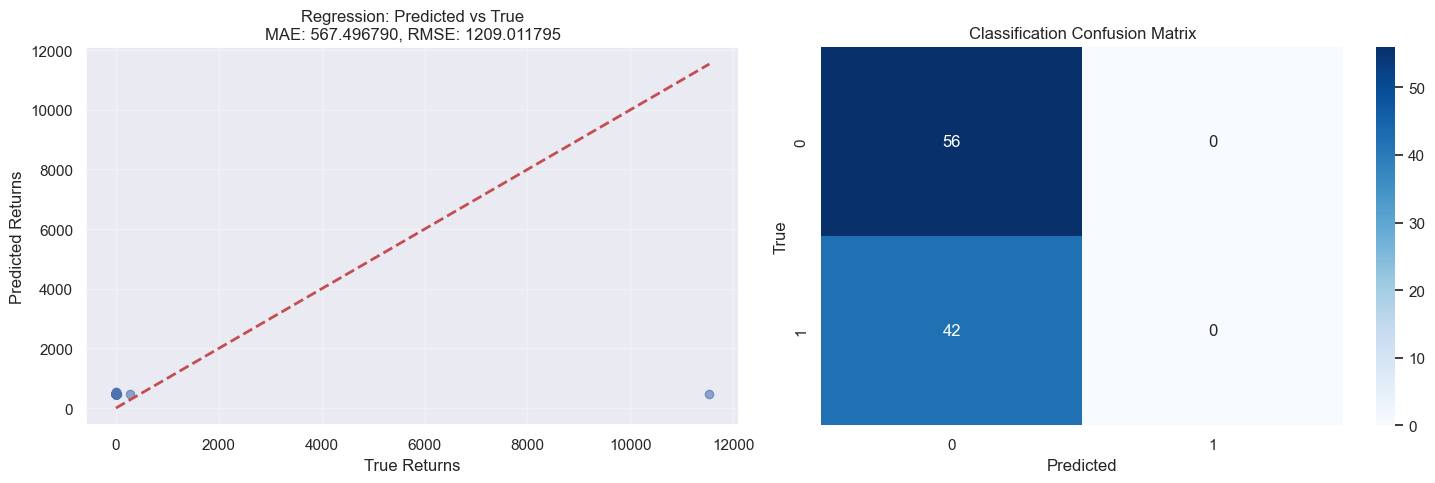

In [9]:
# Subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Regression - Prediction vs Truth
axes[0].scatter(y_test_reg, y_pred_reg, alpha=0.6)
axes[0].plot([y_test_reg.min(), y_test_reg.max()], 
             [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
axes[0].set_xlabel('True Returns')
axes[0].set_ylabel('Predicted Returns')
axes[0].set_title(f'Regression: Predicted vs True\nMAE: {mae:.6f}, RMSE: {rmse:.6f}')
axes[0].grid(True, alpha=0.3)

# Plot 2: Classification - Confusion Matrix
cm = confusion_matrix(y_test_clf, y_pred_clf)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[1], cmap='Blues')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title('Classification Confusion Matrix')

plt.tight_layout()
plt.show()

## Interpretation

### What Works:
- **Feature Engineering**: Lag features capture short-term momentum effects, while rolling statistics provide information about recent trend behavior
- **Pipeline Implementation**: StandardScaler normalizes features with different scales (returns vs volatility measures)
- **Time-Aware Splitting**: The temporal split prevents data leakage by ensuring only historical information is used for predictions

### Limitations and Failures:
- **Low Predictive Power**: Financial returns exhibit high randomness, making accurate forecasting extremely challenging
- **Feature Limitations**: Simple technical indicators may not capture complex market microstructure effects
- **Model Assumptions**: Linear models assume linear relationships, but financial data often displays non-linear patterns and regime changes
- **Stationarity Issues**: Return series may not be stationary, violating key assumptions of linear regression

### Where Assumptions Break:
1. **Market Regime Changes**: Models trained during calm periods may fail during high volatility or crisis periods
2. **Structural Breaks**: Major economic events or policy changes can fundamentally alter price dynamics
3. **Overfitting to Noise**: Short-term patterns in training data may represent noise rather than signal
4. **Feature Instability**: Rolling statistics become unreliable during periods of low trading volume or market gaps
5. **Non-Constant Volatility**: The assumption of constant error variance is violated in financial time series

### Potential Improvements:
- Incorporate volatility clustering models (GARCH-type)
- Add regime-switching indicators or market stress measures
- Implement ensemble methods combining multiple model types
- Use walk-forward validation to account for time-varying relationships
- Consider transaction costs and realistic implementation constraints
- Add external variables like economic indicators or market sentiment measures

### Risk Assessment:
The model's performance should be evaluated across different market conditions. High accuracy during training periods may not translate to reliable performance during market stress, making robust risk management essential for any practical application.